In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dopplerShift_Radio import dopplerShiftFreqRadio
from scipy import interpolate
import os

In [2]:
pdr="spectra/"

In [28]:
# esta función lee los espectros, pone ceros entre las ventanas espectrales y los organiza
def read_sp(oname):
    sp=np.array([np.loadtxt(oname+"%i.txt"%i) for i in range(4)]).reshape(-1,2) # pone iterativamente los datos de las spw en la variable sp
    sp=sp[sp[:,0].argsort()] # ordena el espectro por orden de frecuencia
    # el siguiente bloque pone dos puntos donde flujo=cero entre cada par de ventanas espectrales
    # estos puntos están muy cerca de cada ventana espectral
    # es decir si las spw son p.ej. freq= 100-150 y 150-200, se crean dos datos donde flujo=0, uno en 151 y otro en 149
    # aquí se hace de manera automatizada, mirando la distribución de intervalos entre frecuencias adyacentes
    fr=sp[:,0] # array con las frecuencias
    ints=fr[1:]-fr[:-1] # array con los intervalos entre frecuencias adyacentes
    mnlim=np.percentile(ints,99) # el 99% de intervalos es menor a mlim (~1e-3)
    mxlim=ints[ints>mnlim].min() # encontramos el mínimo de los intervalos que son mayores a mnlim (~1e-2) -> se identifican los "huecos" entre spw
    fz=fr[:-1][ints>=mxlim]+mnlim # creamos datos de frecuencia situados a un mnlim a la der de cada spw < 3
    fz=np.hstack((fz,fr[1:][ints>=mxlim]-mnlim)) # creamos datos de frecuencia situados a un mnlim a la izq de cada spw > 0
    zf=np.zeros(len(fz)) # crea flujos = 0 para esas frecuencias
    sp=np.vstack((sp,np.array([fz,zf]).T)) # añade estos flujos = 0 a sp
    sp=sp[sp[:,0].argsort()] # ordena de nuevo el espectro por orden de frecuencia
    print(oname)
    print(fz[:3])
    return sp

In [29]:
entries=list(os.scandir(pdr)) # mira los contenidos de la carpeta "spectra/"

In [30]:
olist=np.unique([str(i)[11:][:-7] for i in entries]) # convierte los contenidos en array de nombres de objeto

In [31]:
splist=[read_sp(pdr+i) for i in olist ] # con la lista anterior corre la función de arriba

spectra/G013.6562_spw
[ 226.11102295  227.99932861  240.69194031]
spectra/G326.6618_spw
[ 226.11047363  227.99926758  240.69226074]
spectra/SDC18.816_spw
[ 226.11068726  227.99899292  240.69158936]
spectra/SDC45.787_spw
[ 226.11164856  227.99998474  240.69264221]


SDC45.787 --> V_r_database = 63.0 km/s , V_r_calculated = 61.25 km/s

SDC18.816--> V_r_database = 63.2 km/s , V_r_calculated = 62.00 km/s

G326.6618--> V_r_database = -39.6 km/s , V_r_calculated = -40.50 km/s


In [7]:
velo=[47.5,-40.5,62,61.25] # lista de velocidades -> esto habría que hacerlo automático

In [8]:
# llama la función de PyAstronomy. la modifiqué un poco para que corriera en mi laptop
# pero en principio debería funcionar con la función original de PyAstronomy
dssp=[dopplerShiftFreqRadio(i[:,0],i[:,1],v,fillValue=0,edgeHandling="firstlast") for i,v in zip(splist,velo)]

In [9]:
# este bloque crea una malla de frecuencias para todos los espectros (de todos los objetos)
# es una malla que va desde el mínimo hasta el máximo de frecuencias entre todos los espectros
# y el intervalo entre puntos de la malla es el mínimo intervalo entre frecuencias adyacentes para todos los espectros
allf=[list(i[1]) for i in dssp] # lista con todas las frecuencias de todos los espectros
fmin=np.min(allf) # mínimo entre todas las frecuencias
fmax=np.max(allf) # máximo entre todas las frecuencias
allint=[list(i[1][1:]-i[1][:-1]) for i in dssp] # lista con todos los intervalos entre frecuencias adyacentes de todos los espectros
intmin=np.min(allint) # mínimo intervalo entre todos los espectros
fgnew=np.arange(fmin,fmax,intmin) # malla sintética para la siguiente interpolación

In [18]:
# interpolación de cada espectro a la misma malla sintética
interfl=[interpolate.interp1d(i[1],j[:,1],kind='slinear',bounds_error=False,fill_value=[0])(fgnew) for i,j in zip(dssp,splist)]

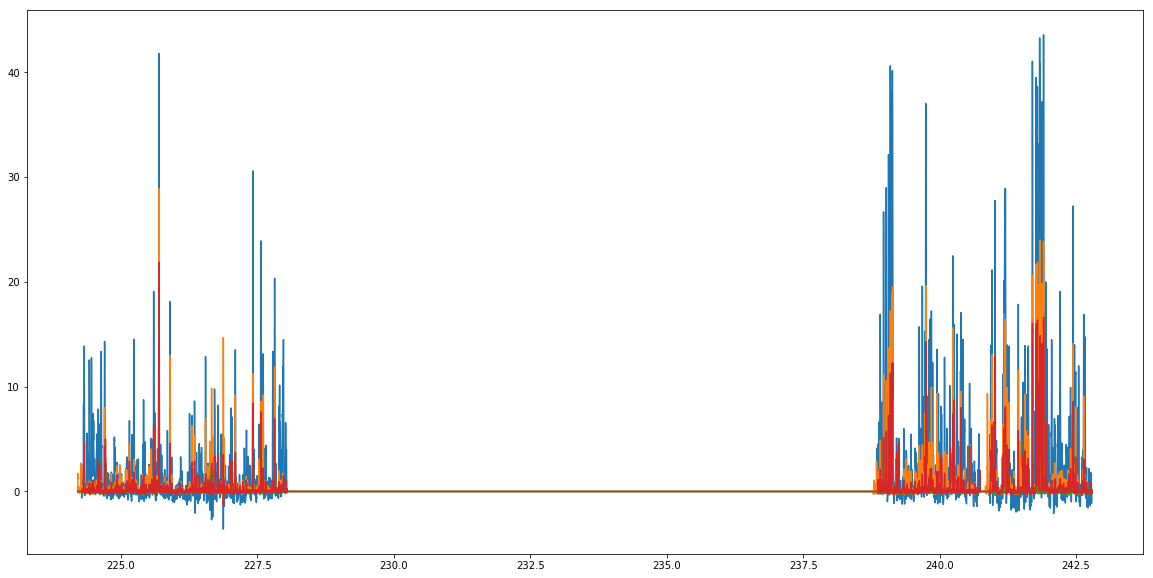

In [23]:
plt.figure(figsize=(20,10))
for i in interfl:
    plt.plot(fgnew,i)

(240, 241.5)

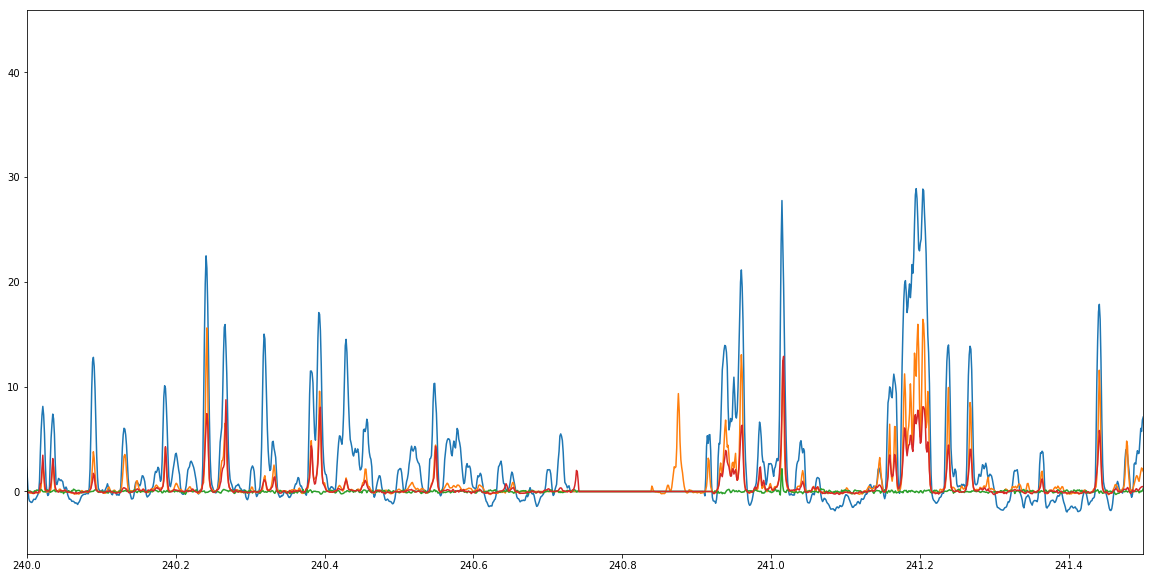

In [24]:
plt.figure(figsize=(20,10))

for i in interfl:
    plt.plot(fgnew,i)
plt.xlim(240,241.5)

(238.7, 239)

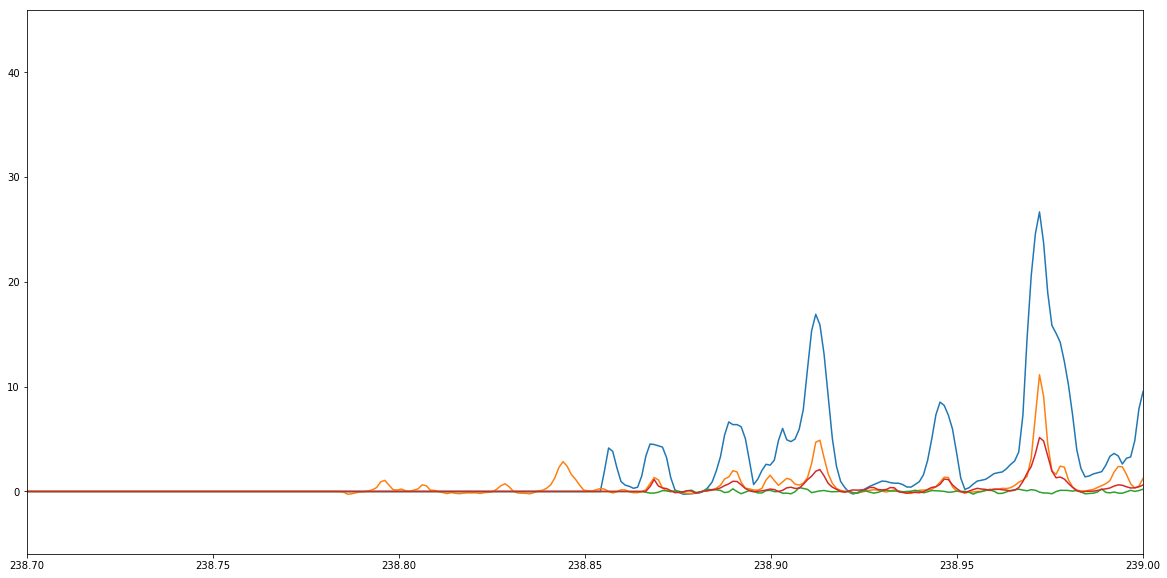

In [36]:
plt.figure(figsize=(20,10))

for i in interfl:
    plt.plot(fgnew,i)
plt.xlim(238.7,239)